<a href="https://colab.research.google.com/github/AmbarM2609/Fashion-Recommendation-Model/blob/main/Fashion_Recommendation_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from keras.applications import vgg16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paramaggarwal/fashion-product-images-small

 98% 554M/565M [00:06<00:00, 99.2MB/s]
100% 565M/565M [00:07<00:00, 84.5MB/s]


In [ ]:
! unzip fashion-product-images-small.zip

Streaming output truncated to the last 5000 lines.
  inflating: myntradataset/images/5813.jpg  
  inflating: myntradataset/images/58131.jpg  
  inflating: myntradataset/images/58132.jpg  
  inflating: myntradataset/images/58133.jpg  
  inflating: myntradataset/images/58135.jpg  
  inflating: myntradataset/images/58136.jpg  
  inflating: myntradataset/images/58137.jpg  
  inflating: myntradataset/images/58138.jpg  
  inflating: myntradataset/images/58139.jpg  
  inflating: myntradataset/images/5814.jpg  
  inflating: myntradataset/images/58140.jpg  
  inflating: myntradataset/images/58141.jpg  
  inflating: myntradataset/images/58143.jpg  
  inflating: myntradataset/images/58144.jpg  
  inflating: myntradataset/images/58145.jpg  
  inflating: myntradataset/images/58146.jpg  
  inflating: myntradataset/images/58147.jpg  
  inflating: myntradataset/images/58148.jpg  
  inflating: myntradataset/images/58149.jpg  
  inflating: myntradataset/images/5815.jpg  
  inflating: myntradataset/image

In [ ]:
styles = pd.read_csv("/content/myntradataset/styles.csv", on_bad_lines='skip')
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
path = '/content/myntradataset'
dataset_path = pathlib.Path(path)
dirs_names = os.listdir(dataset_path) # list content of dataset
dirs_names

['styles.csv', 'images']

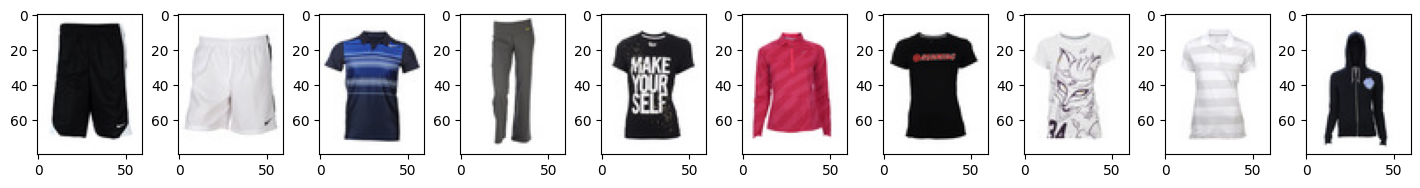

In [ ]:
# Plot samples
plt.figure(figsize=(20,20))
for i in range(20,30):
    plt.subplot(6, 10, i-10+1)
    cloth_img =  mpimg.imread(path + "/images/100" + str(i) +'.jpg') # Assign images ids
    plt.imshow(cloth_img)
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
# Read 6000 product and drop bad lines
styles_df = pd.read_csv(path + "/styles.csv", nrows=6000)

# Make image column contains (id.jpg)
styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1)

# Print the shape of the DataFrame
print(styles_df.shape)

# Print the first 5 rows of the DataFrame
styles_df.head(5)

(6000, 11)


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


<Axes: ylabel='articleType'>

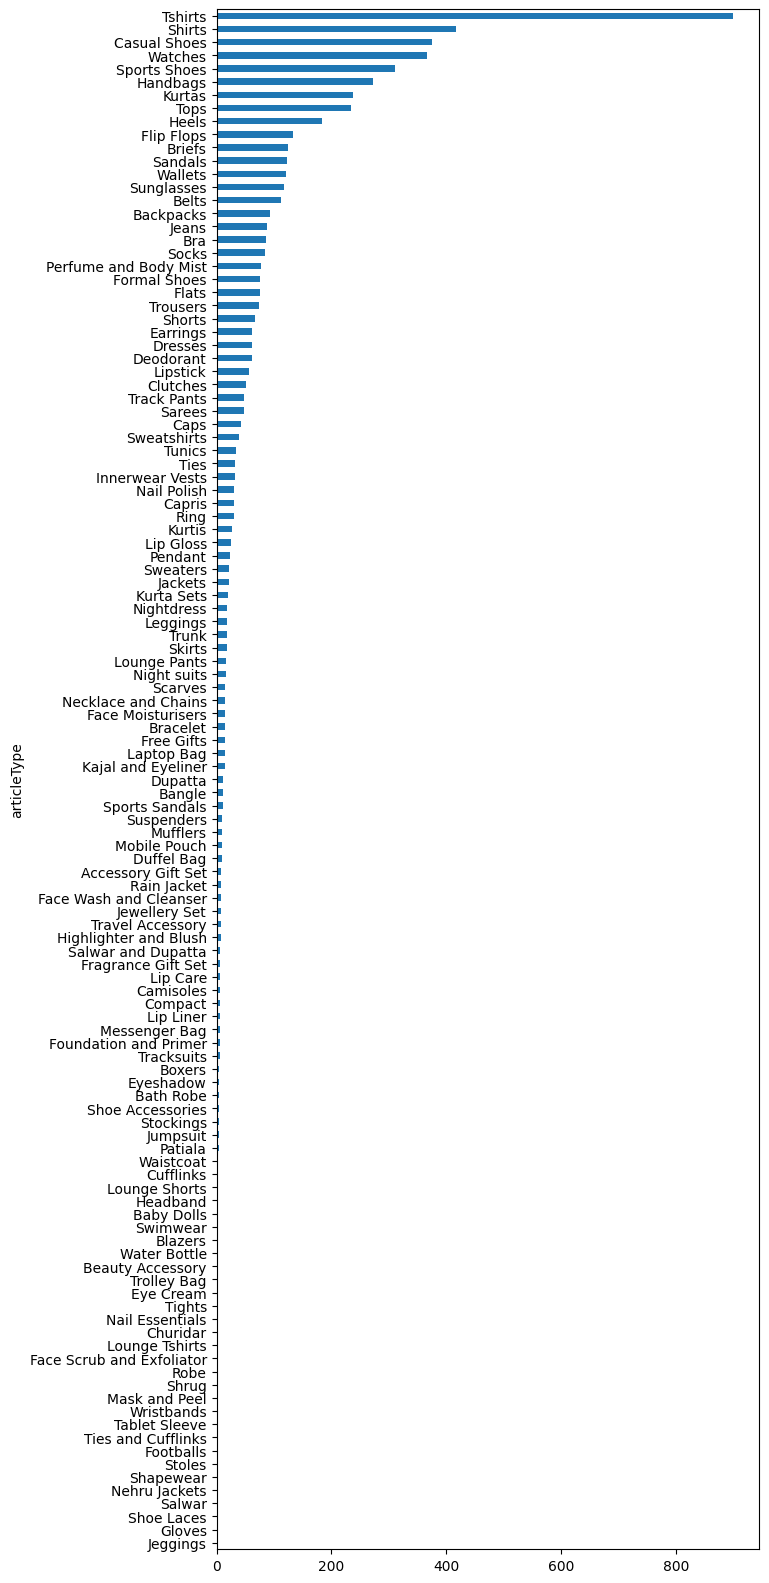

In [ ]:
plt.figure(figsize=(7,20))
styles_df.articleType.value_counts().sort_values().plot(kind='barh')

MODELING AND IMAGE EMBEDDING **bold text**

In [ ]:
img_width, img_height, chnls = 100, 100, 3

In [ ]:
from tensorflow.keras.applications import VGG16

In [ ]:
#VGG16
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(img_width, img_height, chnls))
vgg16.trainable=False
vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
vgg16_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 global_max_pooling2d (Glob  (None, 512)               0         
 alMaxPooling2D)                                                 
                                                                 
Total params: 14714688 (56.13 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [ ]:
def img_path(img):
    """ Take image name(id) and return the complete path of it """
    return path + '/images/' + img

def predict(model, img_name):
    """ Load and preprocess image then make prediction """
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
#     img = image.load_img(os.path.join(path, "images", img_name), target_size=(img_width, img_height))
    # img to Array
    img = image.img_to_array(img)
    # Expand Dim (1, w, h)
    img = np.expand_dims(img, axis=0)
    # Pre process Input
    img = preprocess_input(img)
    return model.predict(img)

In [ ]:
def get_embeddings(df, model):
    """ Return a dataframe contains images features """
    df_copy = df
    df_embeddings = df_copy['image'].apply(lambda x: predict(vgg16_model, x).reshape(-1))
    df_embeddings = df_embeddings.apply(pd.Series)
    return df_embeddings

df_embeddings = get_embeddings(styles_df, vgg16_model)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 226ms/step


In [ ]:
df_embeddings.to_csv("/content/myntradataset/df_embeddings.csv", index=False)

In [ ]:
df_embeddings.head(5)

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,0.000000,0.0,0.000000,0.000000,0.416762,0.000000,0.000000,0.0,0.0,0.0,...,0.465504,2.526569,0.000000,0.000000,0.023387,0.256390,0.000000,0.000000,0.663360,2.707127
1,0.656389,0.0,0.226173,0.000000,0.734096,0.000000,1.910263,0.0,0.0,0.0,...,1.004094,3.999025,0.000000,0.623048,0.519440,0.552858,1.366483,0.992331,0.629040,1.477583
2,0.113616,0.0,0.000000,1.226545,0.866502,0.000000,0.938750,0.0,0.0,0.0,...,1.014141,0.170607,0.000000,0.115413,0.141611,0.493683,0.078028,0.000000,1.143076,0.000000
3,0.000000,0.0,0.000000,0.000000,0.614342,0.000000,0.848840,0.0,0.0,0.0,...,1.126510,2.467212,0.124418,0.000000,0.000000,0.192454,0.507866,0.000000,0.111598,2.579833
4,0.000000,0.0,0.000000,0.000000,0.096241,0.220482,0.000000,0.0,0.0,0.0,...,0.163552,0.334457,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044779,2.458951


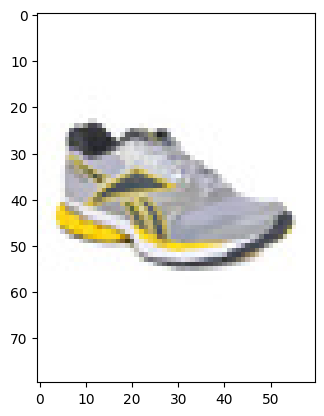

In [ ]:
url="/content/myntradataset/images/10037.jpg"
a = plt.imread(url)
plt.imshow(a)

In [ ]:
sample_image = predict(vgg16_model, '10004.jpg')
sample_image.shape

1/1 [==============================] - 0s 305ms/step


(1, 512)

In [ ]:
df_sample_image = pd.DataFrame(sample_image)
print(df_sample_image)

       0    1    2    3         4    5         6    7    8         9    ...  \
0  0.58663  0.0  0.0  0.0  1.410703  0.0  1.325351  0.0  0.0  0.461285  ...   

        502       503       504       505  506       507  508       509  \
0  1.364411  0.655589  0.080285  0.145576  0.0  0.355453  0.0  0.597836   

        510  511  
0  0.196406  0.0  

[1 rows x 512 columns]


In [ ]:
sample_similarity = linear_kernel(df_sample_image, df_embeddings)
print(sample_similarity)

[[250.78291 376.64594 260.3806  ... 312.4236  290.03513 283.66254]]


In [ ]:
def get_similarity(model):
    """ Get similarity of custom image """
    sample_image = predict(vgg16_model, '10004.jpg')
    df_sample_image = pd.DataFrame(sample_image)
    sample_similarity = linear_kernel(df_sample_image, df_embeddings)
    return sample_similarity

In [ ]:
def normalize_sim(similarity):
    """ Normalize similarity results """
    x_min = similarity.min(axis=1)
    x_max = similarity.max(axis=1)
    norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
    return norm

sample_similarity_norm = normalize_sim(sample_similarity)
sample_similarity_norm.shape

(1, 6000)

In [ ]:
def get_recommendations(df, similarity):
    """ Return the top 5 most similar products """
    # Get the pairwsie similarity scores of all clothes with that one (index, value)
    sim_scores = list(enumerate(similarity[0]))

    # Sort the clothes based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 5 most similar clothes
    sim_scores = sim_scores[0:5]
    print(sim_scores)
    # Get the clothes indices
    cloth_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar products
    return df['image'].iloc[cloth_indices]

[(1387, 1.0), (5508, 0.9878424), (2575, 0.94931304), (2229, 0.8568063), (53, 0.85280263)]


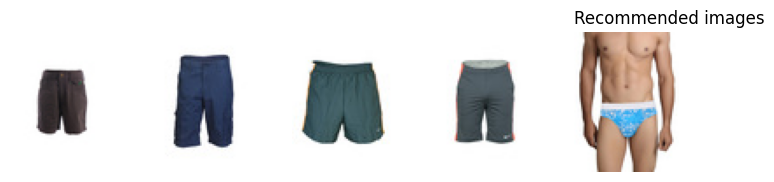

In [ ]:
recommendation = get_recommendations(styles_df, sample_similarity_norm)
recommendation_list = recommendation.to_list()
#recommended images
plt.figure(figsize=(20,20))
j=0
for i in recommendation_list:
    plt.subplot(6, 10, j+1)
    cloth_img =  mpimg.imread(path + '/images/'+ i)
    plt.imshow(cloth_img)
    plt.axis("off")
    j+=1
plt.title("Recommended images",loc='left')
plt.subplots_adjust(wspace=-0.5, hspace=1)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import tensorflow.keras as keras
from keras import Model
from keras.applications.densenet import DenseNet121
from tensorflow.keras.applications import VGG16
from keras.preprocessing import image
from keras.applications.densenet import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
#from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import pathlib
from sklearn.metrics.pairwise import linear_kernel

class fashion_recommendations:
    """ Production class for recommendations of fashion from similarity """

    def __init__(self, img_path, df_embeddings, styles_path):
        self.img_path = img_path
        self.df_embeddings = df_embeddings
        self.styles_path = styles_path
    # Helper functions
    def get_styles_df(self):
        """ Load a dataframe contains styles details and images """
        styles_df = pd.read_csv(self.styles_path, nrows=6000, error_bad_lines=False) # Read 6000 product and drop bad lines
        styles_df['image'] = styles_df.apply(lambda x: str(x['id']) + ".jpg", axis=1) # Make image column contains (id.jpg)
        return styles_df

    def load_model(self):
        """ Load our model """
        vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(100, 100, 3))
        vgg16.trainable=False
        vgg16_model = keras.Sequential([vgg16, GlobalMaxPooling2D()])
        return vgg16_model

    def predict(self, model, img_path):
        """ Load and preprocess image then make prediction """
        # Reshape
        img = image.load_img(self.img_path, target_size=(100, 100)) # đoạn này có thể chuyển thành tải ảnh theo link về
        # img to Array
        img = image.img_to_array(img)
        # Expand Dim (1, w, h)
        img = np.expand_dims(img, axis=0)
        # Pre process Input
        img = preprocess_input(img)
        return model.predict(img)

    def get_similarity(self):
        """ Get similarity of custom image """
        model = self.load_model()
        df_embeddings = self.df_embeddings
        sample_image = self.predict(model, self.img_path)
        df_sample_image = pd.DataFrame(sample_image)
        sample_similarity = linear_kernel(df_sample_image, df_embeddings)
        return sample_similarity

    def normalize_sim(self):
        """ Normalize similarity results """
        similarity = self.get_similarity()
        x_min = similarity.min(axis=1)
        x_max = similarity.max(axis=1)
        norm = (similarity-x_min)/(x_max-x_min)[:, np.newaxis]
        return norm

    def get_recommendations(self):
        """ Get recommended images """
        similarity = self.normalize_sim()
        df = self.get_styles_df()
        # Get the pairwsie similarity scores of all clothes with that one (index, value)
        sim_scores = list(enumerate(similarity[0]))

        # Sort the clothes based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 5 most similar clothes
        sim_scores = sim_scores[0:5]
        print(sim_scores)
        # Get the clothes indices
        cloth_indices = [i[0] for i in sim_scores]

        # Return the top 5 most similar products
        return df['image'].iloc[cloth_indices]

    def print_recommendations(self):
        """ Print the top 5 most similar products"""
        recommendation = self.get_recommendations()
        recommendation_list = recommendation.to_list()
        #recommended images
        plt.figure(figsize=(20,20))
        j=0
        for i in recommendation_list:
            plt.subplot(6, 10, j+1)
            cloth_img =  mpimg.imread("/content/myntradataset" + 'images/'+ i) # Đoạn này trả về id là được
            plt.imshow(cloth_img)
            plt.axis("off")
            j+=1
        plt.title("Recommended images",loc='left')
        plt.subplots_adjust(wspace=-0.5, hspace=1)
        plt.show()
        return



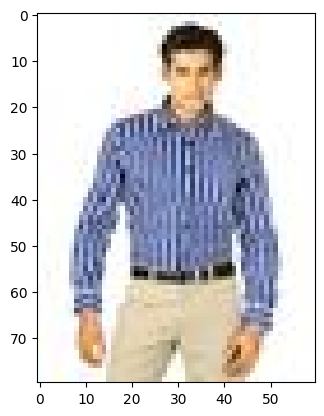

In [ ]:
url = "/content/myntradataset/images/10188.jpg"
a = plt.imread(url)
plt.imshow(a)